# Import Package

In [159]:
# Numerical Operations
import random
import math
import numpy as np

# Reading/Writting Data
import pandas as pd
import os
import cv2

# For Pragress Bar
from tqdm import tqdm

# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torchsummary import summary


# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

# For spiliting the data to train and test
from sklearn.model_selection import train_test_split

# Config

In [119]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 1314520,      # Your seed number, you can pick your lucky number. :)
    'select_all': True,   # Whether to use all features.
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 200,     # Number of epochs.            
    'batch_size': 50, 
    'learning_rate': 0.001,              
    'early_stop': 10,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './model/model.ckpt',  # Your model will be saved here.
    'raw_img_path': './raw_images',
    'processed_img_path': './processed_images',
    'labels': 'labels.csv'
}

# Some Utility Function

In [120]:
def same_seed(seed):
    random.seed(seed) 
    np.random.seed(seed)  
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def train_valid_split(data_set, valid_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(valid_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, 
                                        [train_set_size, valid_set_size], 
                                        generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

def caculate_acc(outputs, labels):
    rightness = 0
    a_word = outputs.size()[1] // 4
    for output_row, label_row in zip(outputs, labels):
        output_index = []
        label_index = []
        for start in range(0, outputs.size()[1], a_word):
            output_index.append(torch.max(output_row[start:start + a_word], 0)[1].item())
            label_index.append(torch.max(label_row[start:start + a_word], 0)[1].item())
        if output_index == label_index:
            rightness += 1
    return rightness

def preprocess(label_file, img_num, img_path, valid_ratio, seed):
    labels = pd.read_csv(label_file).iloc[:, -1].values
    captcha_list = ['2', '3', '4', '5', '6', '7', '8', '9', 
                    'A', 'C', 'D', 'E', 'F', 'G', 'H', 'K', 
                    'M', 'N', 'P', 'Q', 'R', 'T', 'V', 'W', 'Y', 'Z']
    
    all_labels = [] # Y
    all_images = [] # X
    for label in labels[0: img_num]:
        one_hot = np.zeros([len(label) * len(captcha_list)], dtype=float)
        for j, char in enumerate(label):
            index = j * len(captcha_list) + captcha_list.index(char)
            one_hot[index] = 1.0
        all_labels.append(one_hot)
        
    for idx in range(1, img_num + 1):
        # read image
        img = cv2.imread(img_path + '/' + str(idx) + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).reshape([1, 48, 144])
        all_images.append(img)
        
    Y = np.array(all_labels) # Y.shape = [5000, 104]
    X = np.array(all_images, dtype = float) # X.shape = [5000, 1, 48, 140]
    X = X / 255 #standerlize
    x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=valid_ratio, random_state=seed)
    return x_train, x_valid, y_train, y_valid

# Model

In [171]:
image_size  = [48, 144]  #圖像的總尺寸 48*140
num_classes = 104 
depth = [8, 8, 32, 128] 

class ConvNet(nn.Module):
    # Constructor,  __init__ 是create要用的 layer objects (順序無關)
    def __init__(self, ):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, depth[0], 3, padding = 1) 
        self.pool1 = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(depth[1], depth[2], 5, padding = 2)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(depth[2], depth[3], 5, padding = 2)
        self.fc1 = nn.Linear(image_size[0]//8 * image_size[1]//8 * depth[3] , 512)
        self.fc2 = nn.Linear(512, num_classes) 
        

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = x.view(-1, image_size[0]//8 * image_size[1]//8 * depth[3])
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training) 
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x

    # Simulation the CNN for obtaining some features 
    # 將輸入 x, 分別做出 conv1 -> relu 第1層輸出
    #          再做 pooling -> conv2 -> rely 第2層輸出
    def retrieve_features(self, x):
        # For 1 Conv layer
        tempx1 = F.relu(self.conv1(x)) 
        # For 2 Conv layer
        tempx2 = F.relu(self.conv2(self.pool1(tempx1)))
        
        tempx3 = F.relu(self.conv3(self.pool2(tempx2)))
        # 把它從計算圖分離
        tempx1 = tempx1.detach().cpu()
        tempx2 = tempx2.detach().cpu()
        tempx3 = tempx3.detach().cpu()
        # if use_cuda: # 若有用 cuda, 轉回cpu, 後許才好處理
           # tempx1 = tempx1.cpu()
           # tempx2 = tempx2.cpu()           
        return (tempx1, tempx2, tempx3)

print(ConvNet())
summary(ConvNet(), (1, 48, 144), 1, device='cpu')

ConvNet(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(32, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=13824, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=104, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 8, 48, 144]              80
         MaxPool2d-2             [1, 8, 24, 72]               0
            Conv2d-3             [1, 8, 24, 

# Dataset

In [122]:
class CaptchaDataset(Dataset):
    def __init__(self, X, y=None):
        self.data = torch.FloatTensor(X)
        if y is not None:
            self.label = torch.FloatTensor(y)
        else:
            self.label = None

    def __getitem__(self, idx):
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]

    def __len__(self):
        return len(self.data)

# Dataloader

In [123]:
same_seed(config['seed'])

x_train, x_valid, y_train, y_valid = preprocess(label_file=config['labels'], 
                                                img_num=5000, img_path=config['processed_img_path'], 
                                                valid_ratio=config['valid_ratio'], 
                                                seed=config['seed'])
train_dataset, valid_dataset = CaptchaDataset(x_train, y_train), CaptchaDataset(x_valid, y_valid)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)

# Training

In [172]:
model = ConvNet().to(device) 
criterion = nn.BCELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0
writer = SummaryWriter()
if not os.path.exists('model'):
    os.mkdir('model')

best_acc = 0.0
for epoch in range(config['n_epochs']):
    train_acc = 0.0
    train_loss_record = []
    val_acc = 0.0
    val_loss_record = []
    
    # training
    model.train() # set the model to training mode
    for i, batch in enumerate(tqdm(train_loader)):
        features, labels = batch
        features = features.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad() 
        outputs = model(features) 
        
        loss = criterion(outputs, labels)
        loss.backward() 
        optimizer.step()
        step += 1
        
        train_acc += caculate_acc(outputs, labels)
        train_loss_record.append(loss.item())
    mean_train_loss = sum(train_loss_record) / len(train_loss_record)
    # writer.add_scalar('Loss/train', mean_train_loss, epoch)

    # validation
    model.eval() # set the model to evaluation mode
    with torch.no_grad():
        for i, batch in enumerate(tqdm(valid_loader)):
            features, labels = batch
            features = features.to(device)
            labels = labels.to(device)
            outputs = model(features)
            
            loss = criterion(outputs, labels) 
            
            val_acc += caculate_acc(outputs, labels)
            val_loss_record.append(loss.item())
        mean_valid_loss = sum(val_loss_record) / len(val_loss_record)
        writer.add_scalars('Loss', {'train': mean_train_loss, 'valid': mean_valid_loss}, epoch)
        
    print(f'[{epoch+1:03d}/{n_epochs:03d}] Train Acc: {train_acc/len(train_dataset):3.5f} Loss: {mean_train_loss:3.5f} | Val Acc: {val_acc/len(valid_dataset):3.5f} loss: {mean_valid_loss:3.5f}')

    # if the model improves, save a checkpoint at this epoch
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), config['save_path'])
        print(f'saving model with acc {best_acc/len(valid_dataset):.5f}')
        early_stop_count = 0
    else: 
        early_stop_count += 1
    if early_stop_count >= config['early_stop']:
        print('\nModel is not improving, so we halt the training session.')
        break

100%|██████████| 20/20 [00:01<00:00, 19.77it/s]


[001/200] Train Acc: 0.00000 Loss: 0.18542 | Val Acc: 0.00000 loss: 0.15222


100%|██████████| 20/20 [00:01<00:00, 19.61it/s]


[002/200] Train Acc: 0.00000 Loss: 0.15583 | Val Acc: 0.00000 loss: 0.15136


100%|██████████| 20/20 [00:00<00:00, 20.19it/s]


[003/200] Train Acc: 0.00000 Loss: 0.15117 | Val Acc: 0.00400 loss: 0.13728
saving model with acc 0.00400


100%|██████████| 20/20 [00:01<00:00, 19.62it/s]


[004/200] Train Acc: 0.01250 Loss: 0.11915 | Val Acc: 0.10200 loss: 0.09078
saving model with acc 0.10200


100%|██████████| 20/20 [00:01<00:00, 17.23it/s]


[005/200] Train Acc: 0.07225 Loss: 0.09249 | Val Acc: 0.23200 loss: 0.07150
saving model with acc 0.23200


100%|██████████| 20/20 [00:01<00:00, 19.10it/s]


[006/200] Train Acc: 0.17800 Loss: 0.07537 | Val Acc: 0.42100 loss: 0.05527
saving model with acc 0.42100


100%|██████████| 20/20 [00:01<00:00, 18.22it/s]


[007/200] Train Acc: 0.30000 Loss: 0.06079 | Val Acc: 0.57400 loss: 0.04414
saving model with acc 0.57400


100%|██████████| 20/20 [00:01<00:00, 15.38it/s]


[008/200] Train Acc: 0.43825 Loss: 0.04977 | Val Acc: 0.67700 loss: 0.03812
saving model with acc 0.67700


100%|██████████| 20/20 [00:01<00:00, 16.79it/s]


[009/200] Train Acc: 0.54725 Loss: 0.04161 | Val Acc: 0.76100 loss: 0.03090
saving model with acc 0.76100


100%|██████████| 20/20 [00:00<00:00, 20.05it/s]


[010/200] Train Acc: 0.64850 Loss: 0.03496 | Val Acc: 0.82400 loss: 0.02893
saving model with acc 0.82400


100%|██████████| 20/20 [00:01<00:00, 19.17it/s]


[011/200] Train Acc: 0.69250 Loss: 0.03058 | Val Acc: 0.84400 loss: 0.02519
saving model with acc 0.84400


100%|██████████| 20/20 [00:01<00:00, 17.43it/s]


[012/200] Train Acc: 0.75250 Loss: 0.02632 | Val Acc: 0.85700 loss: 0.02362
saving model with acc 0.85700


100%|██████████| 20/20 [00:01<00:00, 19.15it/s]


[013/200] Train Acc: 0.78575 Loss: 0.02383 | Val Acc: 0.89700 loss: 0.02131
saving model with acc 0.89700


100%|██████████| 20/20 [00:00<00:00, 20.28it/s]


[014/200] Train Acc: 0.82125 Loss: 0.02090 | Val Acc: 0.89500 loss: 0.02171


100%|██████████| 20/20 [00:00<00:00, 20.72it/s]


[015/200] Train Acc: 0.84150 Loss: 0.01910 | Val Acc: 0.90600 loss: 0.01937
saving model with acc 0.90600


100%|██████████| 20/20 [00:00<00:00, 20.06it/s]


[016/200] Train Acc: 0.85225 Loss: 0.01815 | Val Acc: 0.90400 loss: 0.01944


100%|██████████| 20/20 [00:01<00:00, 19.92it/s]


[017/200] Train Acc: 0.86675 Loss: 0.01648 | Val Acc: 0.91000 loss: 0.01995
saving model with acc 0.91000


100%|██████████| 20/20 [00:01<00:00, 18.05it/s]


[018/200] Train Acc: 0.88925 Loss: 0.01466 | Val Acc: 0.91700 loss: 0.01901
saving model with acc 0.91700


100%|██████████| 20/20 [00:01<00:00, 19.59it/s]


[019/200] Train Acc: 0.89975 Loss: 0.01403 | Val Acc: 0.91400 loss: 0.01952


100%|██████████| 20/20 [00:01<00:00, 15.99it/s]


[020/200] Train Acc: 0.90875 Loss: 0.01321 | Val Acc: 0.92500 loss: 0.01996
saving model with acc 0.92500


100%|██████████| 20/20 [00:01<00:00, 16.91it/s]


[021/200] Train Acc: 0.91375 Loss: 0.01261 | Val Acc: 0.92500 loss: 0.02061


100%|██████████| 20/20 [00:01<00:00, 17.68it/s]


[022/200] Train Acc: 0.91325 Loss: 0.01193 | Val Acc: 0.92900 loss: 0.01923
saving model with acc 0.92900


100%|██████████| 20/20 [00:01<00:00, 18.52it/s]


[023/200] Train Acc: 0.92550 Loss: 0.01142 | Val Acc: 0.91400 loss: 0.02127


100%|██████████| 20/20 [00:01<00:00, 19.62it/s]


[024/200] Train Acc: 0.92025 Loss: 0.01141 | Val Acc: 0.92600 loss: 0.01940


100%|██████████| 20/20 [00:01<00:00, 19.56it/s]


[025/200] Train Acc: 0.92825 Loss: 0.01109 | Val Acc: 0.93700 loss: 0.01896
saving model with acc 0.93700


100%|██████████| 20/20 [00:01<00:00, 17.26it/s]


[026/200] Train Acc: 0.93825 Loss: 0.01022 | Val Acc: 0.93700 loss: 0.01900


100%|██████████| 20/20 [00:01<00:00, 18.10it/s]


[027/200] Train Acc: 0.94175 Loss: 0.00956 | Val Acc: 0.93000 loss: 0.01938


100%|██████████| 20/20 [00:01<00:00, 18.29it/s]


[028/200] Train Acc: 0.94075 Loss: 0.00950 | Val Acc: 0.93500 loss: 0.01969


100%|██████████| 20/20 [00:01<00:00, 19.73it/s]


[029/200] Train Acc: 0.95625 Loss: 0.00862 | Val Acc: 0.93200 loss: 0.02017


100%|██████████| 20/20 [00:01<00:00, 18.21it/s]


[030/200] Train Acc: 0.95625 Loss: 0.00848 | Val Acc: 0.93500 loss: 0.01946


100%|██████████| 20/20 [00:01<00:00, 17.74it/s]


[031/200] Train Acc: 0.94950 Loss: 0.00842 | Val Acc: 0.94600 loss: 0.01974
saving model with acc 0.94600


100%|██████████| 20/20 [00:01<00:00, 18.90it/s]


[032/200] Train Acc: 0.95950 Loss: 0.00804 | Val Acc: 0.94500 loss: 0.02002


100%|██████████| 20/20 [00:01<00:00, 18.72it/s]


[033/200] Train Acc: 0.95925 Loss: 0.00779 | Val Acc: 0.94200 loss: 0.02111


100%|██████████| 20/20 [00:01<00:00, 19.37it/s]


[034/200] Train Acc: 0.95575 Loss: 0.00798 | Val Acc: 0.94000 loss: 0.01945


100%|██████████| 20/20 [00:01<00:00, 16.95it/s]


[035/200] Train Acc: 0.96075 Loss: 0.00730 | Val Acc: 0.94500 loss: 0.01930


100%|██████████| 20/20 [00:01<00:00, 19.39it/s]


[036/200] Train Acc: 0.96125 Loss: 0.00703 | Val Acc: 0.94500 loss: 0.01958


100%|██████████| 20/20 [00:01<00:00, 19.70it/s]


[037/200] Train Acc: 0.96225 Loss: 0.00700 | Val Acc: 0.95200 loss: 0.01988
saving model with acc 0.95200


100%|██████████| 20/20 [00:00<00:00, 20.32it/s]


[038/200] Train Acc: 0.96800 Loss: 0.00653 | Val Acc: 0.94800 loss: 0.01901


100%|██████████| 20/20 [00:00<00:00, 20.65it/s]


[039/200] Train Acc: 0.96775 Loss: 0.00660 | Val Acc: 0.95400 loss: 0.02026
saving model with acc 0.95400


100%|██████████| 20/20 [00:01<00:00, 18.78it/s]


[040/200] Train Acc: 0.96675 Loss: 0.00653 | Val Acc: 0.95600 loss: 0.01821
saving model with acc 0.95600


100%|██████████| 20/20 [00:01<00:00, 17.78it/s]


[041/200] Train Acc: 0.97100 Loss: 0.00621 | Val Acc: 0.96000 loss: 0.01905
saving model with acc 0.96000


100%|██████████| 20/20 [00:01<00:00, 20.00it/s]


[042/200] Train Acc: 0.97125 Loss: 0.00625 | Val Acc: 0.96100 loss: 0.01929
saving model with acc 0.96100


100%|██████████| 20/20 [00:01<00:00, 17.29it/s]


[043/200] Train Acc: 0.97500 Loss: 0.00548 | Val Acc: 0.96000 loss: 0.01921


100%|██████████| 20/20 [00:01<00:00, 19.40it/s]


[044/200] Train Acc: 0.97525 Loss: 0.00576 | Val Acc: 0.95600 loss: 0.01966


100%|██████████| 20/20 [00:01<00:00, 19.34it/s]


[045/200] Train Acc: 0.97425 Loss: 0.00576 | Val Acc: 0.95900 loss: 0.01875


100%|██████████| 20/20 [00:01<00:00, 19.69it/s]


[046/200] Train Acc: 0.97350 Loss: 0.00566 | Val Acc: 0.95700 loss: 0.01899


100%|██████████| 20/20 [00:01<00:00, 19.11it/s]


[047/200] Train Acc: 0.97400 Loss: 0.00558 | Val Acc: 0.95900 loss: 0.01877


100%|██████████| 20/20 [00:01<00:00, 18.54it/s]


[048/200] Train Acc: 0.97625 Loss: 0.00544 | Val Acc: 0.96200 loss: 0.01870
saving model with acc 0.96200


100%|██████████| 20/20 [00:01<00:00, 18.56it/s]


[049/200] Train Acc: 0.97350 Loss: 0.00570 | Val Acc: 0.95900 loss: 0.01903


100%|██████████| 20/20 [00:01<00:00, 18.82it/s]


[050/200] Train Acc: 0.97875 Loss: 0.00538 | Val Acc: 0.96200 loss: 0.01966


100%|██████████| 20/20 [00:01<00:00, 15.06it/s]


[051/200] Train Acc: 0.97300 Loss: 0.00525 | Val Acc: 0.95800 loss: 0.01975


100%|██████████| 20/20 [00:01<00:00, 18.56it/s]


[052/200] Train Acc: 0.98350 Loss: 0.00487 | Val Acc: 0.95800 loss: 0.02067


100%|██████████| 20/20 [00:01<00:00, 16.63it/s]


[053/200] Train Acc: 0.98000 Loss: 0.00476 | Val Acc: 0.96700 loss: 0.01941
saving model with acc 0.96700


100%|██████████| 20/20 [00:01<00:00, 17.77it/s]


[054/200] Train Acc: 0.98150 Loss: 0.00505 | Val Acc: 0.95900 loss: 0.02012


100%|██████████| 20/20 [00:01<00:00, 19.88it/s]


[055/200] Train Acc: 0.98100 Loss: 0.00455 | Val Acc: 0.96200 loss: 0.01958


100%|██████████| 20/20 [00:01<00:00, 19.09it/s]


[056/200] Train Acc: 0.98150 Loss: 0.00477 | Val Acc: 0.96200 loss: 0.02064


100%|██████████| 20/20 [00:01<00:00, 19.11it/s]


[057/200] Train Acc: 0.98450 Loss: 0.00449 | Val Acc: 0.96200 loss: 0.02104


100%|██████████| 20/20 [00:01<00:00, 16.63it/s]


[058/200] Train Acc: 0.98350 Loss: 0.00428 | Val Acc: 0.96700 loss: 0.02096


100%|██████████| 20/20 [00:01<00:00, 17.54it/s]


[059/200] Train Acc: 0.98475 Loss: 0.00428 | Val Acc: 0.96700 loss: 0.02047


100%|██████████| 20/20 [00:01<00:00, 18.02it/s]


[060/200] Train Acc: 0.98850 Loss: 0.00414 | Val Acc: 0.96700 loss: 0.02014


100%|██████████| 20/20 [00:01<00:00, 15.32it/s]


[061/200] Train Acc: 0.98350 Loss: 0.00417 | Val Acc: 0.96700 loss: 0.02030


100%|██████████| 20/20 [00:01<00:00, 18.92it/s]


[062/200] Train Acc: 0.98200 Loss: 0.00428 | Val Acc: 0.96500 loss: 0.01976


100%|██████████| 20/20 [00:01<00:00, 20.00it/s]

[063/200] Train Acc: 0.98350 Loss: 0.00407 | Val Acc: 0.96500 loss: 0.02124

Model is not improving, so we halt the training session.


In [173]:
%reload_ext tensorboard
%tensorboard --logdir=./runs/

Reusing TensorBoard on port 6006 (pid 3280), started 1 day, 12:57:49 ago. (Use '!kill 3280' to kill it.)

"\n# 5.2.3 Draw the 8 feature maps by conv3\nplt.figure(figsize = (10, 32))\n#plt.suptitle('The image processed by conv3 (128 filters)')\nfor i1 in range(128):\n    plt.subplot(32,4,i1 + 1)\n    plt.axis('off')\n    plt.imshow(feature_maps[2][0, i1])\n"

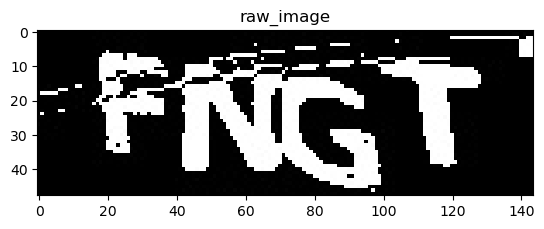

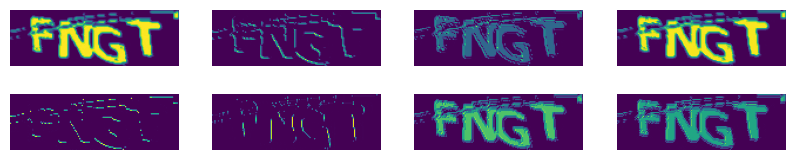

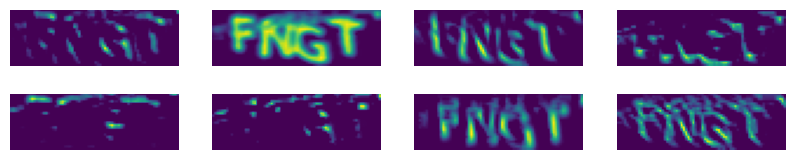

In [178]:
idx = 500

# img_path = config['processed_img_path']
img_path =r'./test_images'
img = cv2.imread(img_path + '/' + str(idx) + '.jpg')
plt.figure()
plt.title('raw_image')
plt.imshow(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).reshape([1, 48, 144])
x = img.reshape([1, 1, 48, 144])



# x = X_test[idx].reshape([1, 1, 48, 140])
input_x = torch.tensor(x, dtype = torch.float).to(device)
feature_maps = model.retrieve_features(input_x)


plt.figure(figsize = (10, 2))

for i1 in range(8):
    plt.subplot(2,4,i1 + 1)
    plt.axis('off')
    plt.imshow(feature_maps[0][0, i1])

# 5.2.2 Draw the 8 feature maps by conv2
plt.figure(figsize = (10, 2))
#plt.suptitle('The image processed by conv2 (32 filters)')
for i1 in range(8):
    plt.subplot(2,4,i1 + 1)
    plt.axis('off')
    plt.imshow(feature_maps[1][0, i1])

'''
# 5.2.3 Draw the 8 feature maps by conv3
plt.figure(figsize = (10, 32))
#plt.suptitle('The image processed by conv3 (128 filters)')
for i1 in range(128):
    plt.subplot(32,4,i1 + 1)
    plt.axis('off')
    plt.imshow(feature_maps[2][0, i1])
'''

In [179]:
captcha_list = ['2', '3', '4', '5', '6', '7', '8', '9', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'K', 'M', 'N', 'P', 'Q', 'R', 'T', 'V', 'W', 'Y', 'Z']
model.eval()
a = model(input_x)
guess_idx = []
for start in range(0, 104, 26):
    end = start + 26
    if end >= 104:
        end = 104
    guess_idx.append(torch.max(a[:,start:end], 1)[1] + start)
code = ''
for i, arow in enumerate(guess_idx):
    code += str(captcha_list[int(arow.item()) - (i * 26)])
print("The code is:", code)  

The code is: 2NQT
